# Heart Disease — Part 2: FastAPI microservice
This notebook is **the second part**: the correct connection with the pipeline from Part 1 and the deployment of the microservice via FastAPI.

What are we doing:
1) Create a module `feature_engineering.py ` (fit + transform artifacts).
2) We prepare and save `artifacts.joblib` and `model.joblib' (XGBoost).
3) Create `app.py ` (FastAPI) and launch the service via `uvicorn`.

In the **fit** product, it is done offline once, in the API — only **transform + predict**.

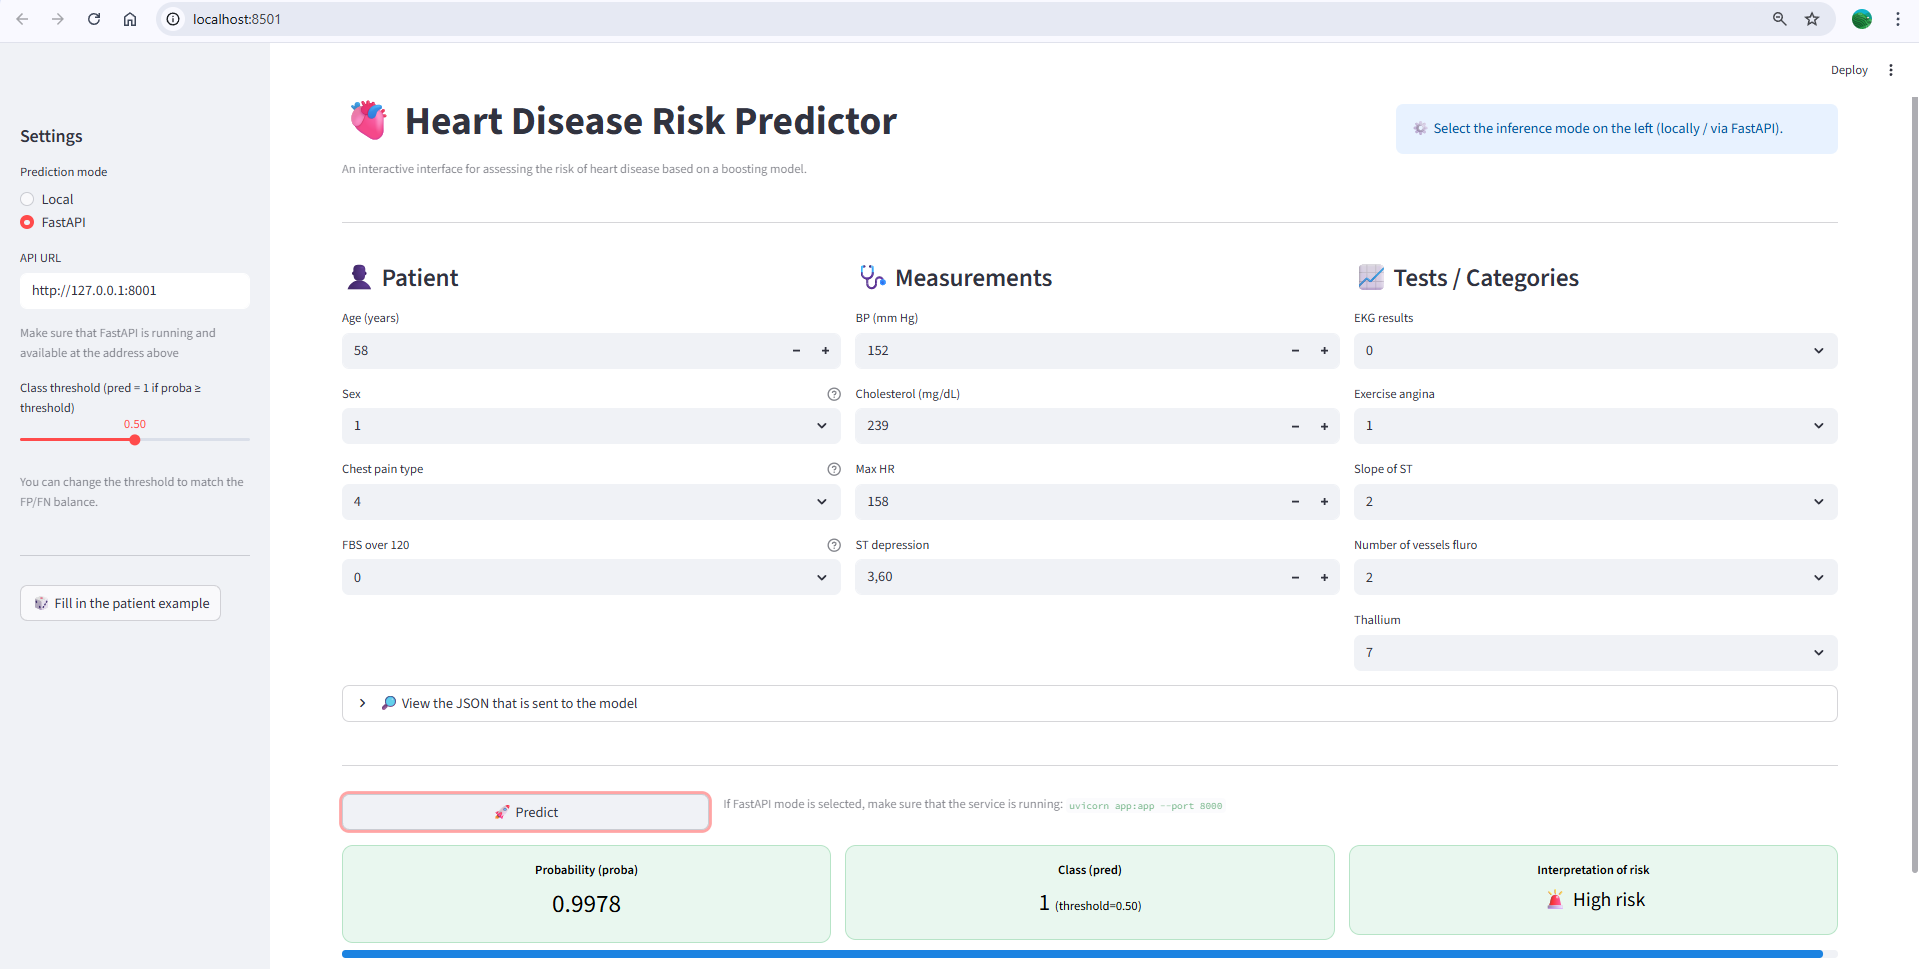

In [16]:
from IPython.display import Image
Image("StreamLit_UI.png")

## 0) Installing dependencies (AnacondaNavigator)

Open AnacondaNavigator -> Anaconda PowerShell -> conda deactivate -> Create an environment with Python=3.10 and install the following dependencies:

```bash
pip install fastapi uvicorn[standard] pydantic pandas numpy joblib scikit-learn
pip install xgboost lightgbm catboost
```

Check dependencies:
```bash
python -c "import fastapi, uvicorn, pandas, numpy, joblib; print('OK')"
```

## 1) Data paths

The files should be placed next to the notebook.:
- `train.csv`
- `test.csv`
- `original.csv`

In [5]:
import pandas as pd
import numpy as np

TRAIN_PATH  = "train.csv"
TEST_PATH   = "test.csv"
ORIGIN_PATH = "original.csv"

df_train  = pd.read_csv(TRAIN_PATH)
df_test   = pd.read_csv(TEST_PATH)
df_origin = pd.read_csv(ORIGIN_PATH)

target = "Heart Disease"

print(df_train.shape, df_test.shape, df_origin.shape)
print("Train target dtype:", df_train[target].dtype)
df_train.head()

(630000, 15) (270000, 14) (270, 14)
Train target dtype: object


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


## 2) Target coding

The target string (object type) in the source files.
For training/metrics, we need a LabelEncoder() at 0/1.

It is important to use **the same encoder** for the `train` and `origin` files.

In [6]:
from sklearn.preprocessing import LabelEncoder

if df_train[target].dtype == "object":
    le = LabelEncoder()
    df_train[target]  = le.fit_transform(df_train[target].astype(str))
    df_origin[target] = le.transform(df_origin[target].astype(str))
else:
    df_train[target]  = df_train[target].astype(int)
    df_origin[target] = df_origin[target].astype(int)

print("Target unique (train):", np.unique(df_train[target]))
print("Target unique (origin):", np.unique(df_origin[target]))

Target unique (train): [0 1]
Target unique (origin): [0 1]


## 3) Create `feature_engineering.py `

This is the module that will be used:
- in the notebook (for artifact training and build_features() for model training/validation)
- in FastAPI (using only build_features)

**What's inside:**
- `add_interactions` — interaction features
- `FEArtifacts` — container of artifacts
- `fit_artifacts` — **train-time**: builds maps/edges/encoders/origin stats/qcut edges/label+freq)
- `build_features` — **inference-time**: builds features for the model

In [7]:
%%writefile feature_engineering.py
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple, Any, Optional

import numpy as np
import pandas as pd
from itertools import combinations

def _ensure_columns(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    # Ensure all columns exist; create missing with NaN.
    df = df.copy()
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    return df


def _safe_float32(df):
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_float_dtype(df[c]): # only float!
            df[c] = df[c].astype(np.float32)
    return df


def add_interactions(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    needed = [
              "Age", "Cholesterol", "BP", "Number of vessels fluro", "Thallium",
              "Chest pain type", "Max HR", "ST depression", "Slope of ST",
              "Exercise angina"
             ]
    df = _ensure_columns(df, needed)

    df["age_cholesterol"]       = df["Age"] * df["Cholesterol"]
    df["bp_age"]                = df["BP"] * df["Age"]
    df["vessels_thallium"]      = df["Number of vessels fluro"] * df["Thallium"]
    df["chest_pain_vessels"]    = df["Chest pain type"] * df["Number of vessels fluro"]
    df["hr_age_ratio"]          = df["Max HR"] / (df["Age"] + 1.0)
    df["cholesterol_age_ratio"] = df["Cholesterol"] / (df["Age"] + 1.0)
    df["bp_ratio"]              = df["BP"] / (df["Age"] + 1.0)
    df["heart_risk_score"]      = (df["Thallium"] * 3.0 + df["Chest pain type"] * 2.0 + df["Number of vessels fluro"] * 2.0)
    df["thallium_sq"]           = df["Thallium"] ** 2.0
    df["chest_pain_sq"]         = df["Chest pain type"] ** 2.0
    df["st_slope_interaction"]  = df["ST depression"] * df["Slope of ST"]
    df["exercise_st"]           = df["Exercise angina"] * df["ST depression"]
    return df

#-----------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------
# FEArtifacts is a container where we store everything we “learned” during the preparation stage (fit), so that we can simply apply it later (transform)
@dataclass
class FEArtifacts:
    # Columns
    base_numeric_cols: List[str]                   # default df_train columns
    quantitative_cols: List[str]                   # the numerical attributes (which will go to pd.qcut)
    cross_pairs: List[Tuple[str, str]]             # cross feature [(quantive_col, from base_numeric_cols),(..., ...),...]
    cat_cols_to_label: List[str]                   # LabelEncoder() features

    # original stats (values)
    # Any because the values can be int/float (for example, ST depression — float)
    origin_mean_maps: Dict[str, Dict[Any, float]]  # average value of a feature by target in origin
    origin_count_maps: Dict[str, Dict[Any, float]] # number of feature values by target in origin
    origin_global_mean: float                      # df_origin[target].mean()

    # Qcut edges fixing
    qcut_edges: Dict[str, np.ndarray]              # {feature: array[1., 2., 3.,], ...} 

    # label/frequency encoding values
    label_maps: Dict[str, Dict[str, int]]          # {"quantitative_cols": {"(29.0, 41.0]": LE code_0, "(41.0, 49.0]": LE code_0, "__NA__": LE code_999}}
    freq_maps: Dict[str, Dict[int, float]]         # {"quantitative_cols": {0: freq, 1: 0.22, 999: 0.0001}}
    
    # Final features
    features: List[str]
    
#-----------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------

def fit_artifacts(df_train: pd.DataFrame,
                  df_origin: pd.DataFrame,
                  target: str,
                  quantitative_cols: List[str],
                  n_bins: int = 20,
                  cross_pairs: Optional[List[Tuple[str, str]]] = None,
                  freq_only_for_quant: bool = True,
                 ) -> FEArtifacts:

    # TRAIN-TIME ONLY:
    #- origin stats: mean/count maps from df_origin grouped by numeric values
    #- qcut edges: learned on df_train
    #- label_maps: for Quant_* features
    #- freq_maps: by default only for Quant_*
    #- features: final list in order expected by the model

    df_train = df_train.copy()
    df_origin = df_origin.copy()

    base_numeric_cols = df_train.drop(columns = [target], errors = "ignore").select_dtypes(include=np.number).columns.tolist()

    # 1. Counting statistics variables by origin mean/count maps
    origin_global_mean = float(df_origin[target].mean())
    origin_mean_maps:     Dict[str, Dict[Any, float]] = {}
    origin_count_maps:    Dict[str, Dict[Any, float]] = {}
    for col in base_numeric_cols:
        if col not in df_origin.columns:
            continue
        agg = df_origin.groupby(col)[target].agg(["mean", "count"])
        origin_mean_maps[col] = agg["mean"].to_dict()
        origin_count_maps[col] = agg["count"].to_dict()

    # 2. Counting the bin array "qcut" edges on train
    qcut_edges: Dict[str, np.ndarray] = {}
    for col in quantitative_cols:
        if col not in df_train.columns:
            continue
        # We clean inf, delete NaN
        s = df_train[col].replace([np.inf, -np.inf], np.nan).dropna()
        if s.nunique() < 2:
            continue
        # retbins=True - returns borders
        _, edges = pd.qcut(s, q = n_bins, duplicates = "drop", retbins = True)
        qcut_edges[col] = np.asarray(edges, dtype = np.float64)
    
    # 3. Adding to the List - Quant_* columns and cross cols
    quant_bin_cols = [f"Quant_{c}" for c in quantitative_cols]
    if cross_pairs is None:
        cross_pairs: List[str] = []
        cross_pairs += list(combinations(quant_bin_cols, 2))
        cross_pairs += [
                        ("Quant_Age", "Chest pain type"),
                        ("Quant_Age", "Number of vessels fluro"),
                        ("Quant_ST depression", "Slope of ST"),
                        ("Quant_Max HR", "Exercise angina"),
                        ("Quant_Max HR", "Chest pain type"),
                        ("Quant_ST depression", "Number of vessels fluro"),
                        ("Quant_Cholesterol", "Sex"),
                        ("Quant_BP", "Sex"),
                       ]
    cross_cols = [f"{a}__X__{b}" for a, b in cross_pairs]
    cat_cols_to_label = quant_bin_cols + cross_cols

    # 4. Creating a temporary df to extract categories for Quant_*
    tmp = df_train.drop(columns = [target], errors = "ignore").copy()
    tmp = add_interactions(tmp)
    for col in quantitative_cols:
        qname = f"Quant_{col}"
        if col in qcut_edges:
            tmp[qname] = pd.cut(tmp[col], bins = qcut_edges[col], include_lowest = True).astype(str).fillna("__NA__")
        else:
            tmp[qname] = "__NA__"

    # 5. Cross cols (strings)
    for a, b in cross_pairs:
        cname = f"{a}__X__{b}"
        tmp = _ensure_columns(tmp, [a, b])
        tmp[cname] = tmp[a].astype(str).fillna("__NA__") + "__X__" + tmp[b].astype(str).fillna("__NA__")

    # 6. Label and freq maps
    label_maps: Dict[str, Dict[str, int]]  = {}
    freq_maps: Dict[str, Dict[int, float]] = {}

    for col in cat_cols_to_label:
        vals = tmp[col].astype(str).fillna("__NA__")
        uniq = sorted(pd.unique(vals).tolist())
        label_maps[col] = {v: i for i, v in enumerate(uniq)}

    for col in quant_bin_cols:
        codes = tmp[col].map(label_maps[col]).fillna(-1).astype(int)
        freq = codes.value_counts(normalize=True).to_dict()
        freq_maps[col] = {int(k): float(v) for k, v in freq.items()}

    # 7. Build final features list
    features: List[str] = df_train.drop(columns = [target], errors = "ignore").columns.tolist()
    # Interactions (12 features)
    interaction_cols = [
                        "age_cholesterol", "bp_age", "vessels_thallium", "chest_pain_vessels",
                        "hr_age_ratio", "cholesterol_age_ratio", "bp_ratio", "heart_risk_score",
                        "thallium_sq", "chest_pain_sq", "st_slope_interaction", "exercise_st"
                       ]

    # Interaction features
    features.extend(interaction_cols)
    
    # Origin stats features
    for col in base_numeric_cols:
        if col in origin_mean_maps:
            features.append(f"origin_mean_{col}")
            features.append(f"origin_count_{col}")

    # Quant bins features
    for col in quantitative_cols:
        qname = f"Quant_{col}"
        features.append(qname)

    # Cross features
    features.extend(cross_cols)

    # Freq features
    for col in quant_bin_cols:
        features.append(f"Freq_{col}")

    return FEArtifacts(
                       base_numeric_cols = base_numeric_cols,
                       quantitative_cols = quantitative_cols,
                       cross_pairs = cross_pairs,
                       cat_cols_to_label = cat_cols_to_label,
                       
                       origin_mean_maps = origin_mean_maps,
                       origin_count_maps = origin_count_maps,
                       origin_global_mean = origin_global_mean,
                       
                       qcut_edges = qcut_edges,
        
                       label_maps = label_maps,
                       freq_maps = freq_maps,
                       
                       features = features
                      )

#-----------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------

def build_features(df_raw: pd.DataFrame, artifacts: FEArtifacts) -> pd.DataFrame:
    # INFERENCE-TIME:
    # Apply exactly the same FE as training.
    df = df_raw.copy()

    required = list(set(artifacts.base_numeric_cols + artifacts.quantitative_cols))
    df = _ensure_columns(df, required)

    # 1. interactions
    df = add_interactions(df)

    # 2. origin stats
    for col in artifacts.base_numeric_cols:
        if col not in artifacts.origin_mean_maps:
            continue
        df[f"origin_mean_{col}"]  = df[col].map(artifacts.origin_mean_maps[col]).fillna(artifacts.origin_global_mean).astype(np.float32)
        df[f"origin_count_{col}"] = df[col].map(artifacts.origin_count_maps[col]).fillna(0).astype(np.float32)

    # 3. quant bins
    for col in artifacts.quantitative_cols:
        qname = f"Quant_{col}"
        if col in artifacts.qcut_edges:
            df[qname] = pd.cut(df[col].replace([np.inf, -np.inf], np.nan),
                               bins = artifacts.qcut_edges[col],
                               include_lowest = True
                              ).astype(str).fillna("__NA__")
        else:
            df[qname] = "__NA__"

    # 4. Cross features
    # Cross cols (strings) -> will be label-encoded later
    for a, b in artifacts.cross_pairs:
        cname = f"{a}__X__{b}"
        df = _ensure_columns(df, [a, b])
        df[cname] = df[a].astype(str).fillna("__NA__") + "__X__" + df[b].astype(str).fillna("__NA__")

    # 5. Label + freq
    for col in artifacts.cat_cols_to_label:
        df[col] = df[col].astype(str).fillna("__NA__")
        mapping = artifacts.label_maps.get(col, {})
        df[col] = df[col].map(mapping).fillna(-1).astype(np.int32)
        # freq only for Quant_
        if col.startswith("Quant_") and "__X__" not in col:
            df[f"Freq_{col}"] = df[col].map(artifacts.freq_maps.get(col, {})).fillna(0.0).astype(np.float32)

    df = _safe_float32(_ensure_columns(df, artifacts.features))
    return df[artifacts.features].copy()

Writing feature_engineering.py


## 4) Fit artifacts + Save (`artifacts.joblib`)

We do this **once** offline. We only upload artifacts to the API.

In [8]:
import joblib
from feature_engineering import fit_artifacts, build_features

quantitative_cols = ["Age", "BP", "Cholesterol", "Max HR", "ST depression"]
artifacts = fit_artifacts(df_train = df_train,
                          df_origin = df_origin,
                          target = target,
                          quantitative_cols = quantitative_cols,
                          n_bins = 20,
                          cross_pairs = None,
                          freq_only_for_quant = True
                          )

joblib.dump(artifacts, "artifacts.joblib")
print("artifacts.joblib saved successfully")

X_full = build_features(df_train.drop(columns = [target]), artifacts).drop(columns = "id")
y_full = df_train[target].astype(int).values

FEATURES = X_full.columns.tolist()
joblib.dump(FEATURES, "features.joblib")
print("features.joblib saved successfully")
print("X_full:", X_full.shape, "y_full:", y_full.shape)

artifacts.joblib saved successfully
features.joblib saved successfully
X_full: (630000, 79) y_full: (630000,)


## 5) Training/saving the final model in `model.joblib`

The microservice uses **one** final trained model

In [9]:
import xgboost as xgb

best_xgb_params = {"n_estimators": 3000,
                   "learning_rate": 0.04,
                   "max_depth": 4,
                   "min_child_weight": 2.0,
                   "subsample": 0.7,
                   "colsample_bytree": 0.7,
                   "gamma": 1.0,
                   "reg_alpha": 1e-6,
                   "reg_lambda": 1e-3,
                   "max_bin": 256,
    
                   "objective": "binary:logistic",
                   "eval_metric": "auc",
                   "tree_method": "hist",
                   "device": "cuda",
                   "random_state": 42
                  }

model = xgb.XGBClassifier(**best_xgb_params)
model.fit(X_full, y_full)

joblib.dump(model, "model.joblib")
joblib.dump(model, "model.json")
print("Saved model.joblib and model.json")

Saved model.joblib and model.json


## 6) Create `app.py` (FastAPI microservice)

- Download `model.joblib` and `artifacts.joblib'
- We describe the login scheme via Pydantic (`Patient`)
- `/health` — verification that the service is alive
- `/predict` — prediction of probability and class (0/1)

In [10]:
%%writefile app.py
from __future__ import annotations

import numpy as np
import pandas as pd
import joblib
from pydantic import BaseModel, Field

from fastapi import FastAPI
from fastapi.responses import JSONResponse
import traceback

import xgboost as xgb
import cupy as cp

from feature_engineering import build_features, FEArtifacts

app = FastAPI(title = "Heart Disease Predictor", version = "1.0.0")

# Load model + artifacts once on startup
model = joblib.load("model.joblib")
booster = model.get_booster()
artifacts: FEArtifacts = joblib.load("artifacts.joblib")

THRESHOLD = 0.5


class Patient(BaseModel):
    Age: int = Field(..., ge = 0, le = 120)
    Sex: int = Field(..., ge = 0, le = 1)

    Chest_pain_type: int = Field(..., ge = 1, le = 4, alias = "Chest pain type")
    BP: int = Field(..., ge = 0, le = 300)
    Cholesterol: int = Field(..., ge = 0, le = 700)

    FBS_over_120: int = Field(..., ge = 0, le = 1, alias = "FBS over 120")
    EKG_results: int = Field(..., ge = 0, le = 2, alias = "EKG results")

    Max_HR: int = Field(..., ge = 0, le = 250, alias = "Max HR")
    Exercise_angina: int = Field(..., ge = 0, le = 1, alias = "Exercise angina")

    ST_depression: float = Field(..., ge = 0, le = 10, alias = "ST depression")
    Slope_of_ST: int = Field(..., ge = 0, le = 3, alias = "Slope of ST")

    Number_of_vessels_fluro: int = Field(..., ge = 0, le = 3, alias = "Number of vessels fluro")
    Thallium: int = Field(..., ge = 0, le = 7)


@app.get("/health")
def health():
    # Quick check that the service is alive (without calculating the features/model)
    return {"status": "ok"}


@app.post("/predict")
def predict(patient: Patient):
    # Convert request -> DataFrame with original column names (aliases)
    row = patient.model_dump(by_alias = True)
    df = pd.DataFrame([row])

    # Feature engineering (same as training)
    X = build_features(df, artifacts)
    FEATURES = joblib.load("features.joblib")
    #X = X.reindex(columns = FEATURES, fill_value = 0)
    
    if "id" in X.columns:
        X = X.drop(columns = ["id"])
    bad = X.select_dtypes(include = ["object"]).columns.tolist()
    if bad:
        return {"error": f"Object columns found: {bad}"}

    # GPU inference
    X_gpu = cp.asarray(X.values, dtype = cp.float32)
    dmat = xgb.DMatrix(X_gpu, feature_names = FEATURES)
    proba = float(booster.predict(dmat)[0])
    pred = int(proba >= THRESHOLD)

    return {"proba": proba, "pred": pred}

Writing app.py


### 6.1 Start FastAPI prediction:
- ! cd "C:\Users\Users\Jupyer Notebook Projects\Heart Disease"
- ! python -m uvicorn app:app --host 127.0.0.1 --port 8001 --reload
- Google: http://127.0.0.1:8001/docs 

## 7) Create and Launching Streamlit UI (user interface)


To launch the UI, run only this code. In PowerShell, enter the working directory:
- cd "C:\Users\Users\Jupyer Notebook Projects\Heart Disease"

Enter the command:
- python -m streamlit run streamlit_app.py
- http://localhost:8500

The service offers the possibility of 1. local forecast via UI Streamlit and 2. direct forecast via FastAPI

🔹 Local mode (joblib inside Streamlit)

How it works:
- Streamlit directly loads model.joblib and artifacts.joblib
- Calls build_features() and model.predict_proba() in the same process

Plus:
- ⚡ Faster (no network request)
- 🧩 Easier (one service, fewer moving parts)
- 🛠 Convenient for prototypes, demos, research
- 📴 Works offline

Minus:
- 🚫 Does not scale (one process = one model)
- 🔒 The model “leaks" into the UI (less secure)
- 🔁 It is difficult to update the model regardless of the interface

When to choose:
- local development
- demo for presentation
- laptop for a doctor/analyst
- PoC / MVP

🔹 Mode via FastAPI (UI → API → model)

How it works:
- Streamlit is just a UI
- It sends JSON to FastAPI (/predict)
- FastAPI loads the model inside, makes FE and inference
- Streamlit receives a response

Plus:
- 🏗 Production approach (UI and model are separated)
- 🔐 The model is hidden behind the API
- 📈 Easy to scale (multiple API instances)
- 🔄 You can update the model without restarting the UI
- 🤝 You can connect other clients (mobile phone, website, other services)

Minus:
- 🐢 Slightly slower (network call)
- 🧱 The infrastructure is more complicated (2 services instead of 1)
- ⚙️ You need to monitor API and FE versions

When to choose:
- preparation for production
- multiple clients (web, mobile app)
- microservice architecture
- deploy to the cloud

In [17]:
# conda-forge cupy
# Name                     Version           Build            Channel
#cudatoolkit                11.2.2           h7d7167e_13      conda-forge
#cupy                       13.6.0           py310h9a275d0_2  conda-forge
#cupy-core                  13.6.0           py310h51ad24f_2  conda-forge
import cupy as cp

print("CuPy version:", cp.__version__)
print("Device count:", cp.cuda.runtime.getDeviceCount())

props = cp.cuda.runtime.getDeviceProperties(0)
print("GPU:", props["name"].decode())
print("Mem GB:", props["totalGlobalMem"] / 1024**3)

#x = cp.random.rand(1_000_000).astype(cp.float32)
#print("GPU calc OK:", float(x.mean()))

CuPy version: 13.6.0
Device count: 1
GPU: NVIDIA GeForce RTX 5060 Ti
Mem GB: 15.92816162109375


In [12]:
%%writefile streamlit_app.py
from pathlib import Path
import pandas as pd
import numpy as np
import joblib

import cupy as cp
import xgboost as xgb

import streamlit as st
import requests

# For Local prediction
from feature_engineering import build_features 

# Page config
st.set_page_config(page_title = "Heart Disease Risk Predictor",
                   page_icon  = "🫀",
                   layout     = "wide",
                  )

# Styling
st.markdown("""
            <style>
            .block-container { padding-top: 1.5rem; padding-bottom: 2rem; }
            .stMetric { background: #0b1220; padding: 14px; border-radius: 14px; }
            div[data-testid="stMetricValue"] { font-size: 26px; }
            </style>
            """,
            unsafe_allow_html = True, #!!!
           )

BASE_DIR = Path(__file__).resolve().parent

# Caching model/artifacts
@st.cache_resource
def load_local_assets():
    model     = joblib.load(BASE_DIR / "model.joblib")
    artifacts = joblib.load(BASE_DIR / "artifacts.joblib")
    # This is optional: a joblib file for the correct feature order
    features_path = BASE_DIR / "features.joblib"
    if features_path.exists():
        features = joblib.load(features_path)
    else:
        features = getattr(artifacts, "features", None)
    return model, artifacts, features

def make_payload(Age, Sex, ChestPain, BP, Chol, FBS, EKG, MaxHR, ExAng, STdep, SlopeST, Vessels, Thallium):
    # Important: the keys must match the names in feature_engineering
    return {"Age":                     int(Age),
            "Sex":                     int(Sex),
            "Chest pain type":         int(ChestPain),
            "BP":                      int(BP),
            "Cholesterol":             int(Chol),
            "FBS over 120":            int(FBS),
            "EKG results":             int(EKG),
            "Max HR":                  int(MaxHR),
            "Exercise angina":         int(ExAng),
            "ST depression":           float(STdep),
            "Slope of ST":             int(SlopeST),
            "Number of vessels fluro": int(Vessels),
            "Thallium":                int(Thallium),
           }

def predict_local(payload: dict):
    model, artifacts, features = load_local_assets()
    # GPU inference don't support via DMatrix, only CPU
    model.set_params(device = "cpu")
    df = pd.DataFrame([payload])
    X = build_features(df, artifacts)

    # Protection against the parasitic column "id"
    if "id" in X.columns:
        X = X.drop(columns = ["id"])

    # Guarantee the order of the columns
    if features is not None:
        X = X.reindex(columns = features, fill_value = 0)

    proba = float(model.predict_proba(X)[:, 1][0])
    return proba

def predict_via_api(payload: dict, api_url: str):
    r = requests.post(api_url.rstrip("/") + "/predict", json = payload, timeout = 10)
    r.raise_for_status()
    data = r.json()
    return float(data["proba"])

# Conf of prediction (risk label)
def risk_label(p: float):
    if p < 0.33:
        return "Low risk", "✅"
    elif p < 0.66:
        return "Medium риск", "⚠️"
    return "High risk", "🚨"

# Header
left, right = st.columns([0.7, 0.3], 
                         vertical_alignment = "center")
with left:
    st.title("🫀 Heart Disease Risk Predictor")
    st.caption("An interactive interface for assessing the risk of heart disease based on a boosting model.")
with right:
    st.info("⚙️ Select the inference mode on the left (locally / via FastAPI).")
st.divider()

# Sidebar settings
st.sidebar.header("Settings")
mode = st.sidebar.radio("Prediction mode", ["Local", "FastAPI"], index = 0)
api_url = None
if mode == "FastAPI":
    api_url = st.sidebar.text_input("API URL", value = "http://127.0.0.1:8000")
    st.sidebar.caption("Make sure that FastAPI is running and available at the address above")
threshold = st.sidebar.slider("Class threshold (pred = 1 if proba ≥ threshold)", 0.1, 0.9, 0.5, 0.01)
st.sidebar.caption("You can change the threshold to match the FP/FN balance.")
st.sidebar.divider()
if st.sidebar.button("🎲 Fill in the patient example"):
    st.session_state["example"] = True

# Input form
col1, col2, col3 = st.columns([0.34, 0.33, 0.33])
example = st.session_state.get("example", False)
with col1:
    st.subheader("👤 Patient")
    Age = st.number_input("Age (years)", min_value = 0, max_value = 120, value = 58 if example else 50, step = 1)
    Sex = st.selectbox("Sex", options = [0, 1], index = 1 if example else 0, help = "0 = Female, 1 = Male")
    ChestPain = st.selectbox("Chest pain type", options = [1, 2, 3, 4], index = 3 if example else 0,
                             help = "1 Typical angina, 2 Atypical, 3 Non-anginal, 4 Asymptomatic")
    FBS = st.selectbox("FBS over 120", options = [0, 1], index = 0 if example else 0, help = "1 = True, 0 = False")
with col2:
    st.subheader("🩺 Measurements")
    BP = st.number_input("BP (mm Hg)", min_value = 0, max_value = 300, value = 152 if example else 130, step = 1)
    Chol = st.number_input("Cholesterol (mg/dL)", min_value = 0, max_value = 700, value = 239 if example else 200, step = 1)
    MaxHR = st.number_input("Max HR", min_value = 0, max_value = 250, value = 158 if example else 150, step = 1)
    STdep = st.number_input("ST depression", min_value = 0.0, max_value = 10.0, value = 3.6 if example else 1.0, step = 0.1)
with col3:
    st.subheader("📈 Tests / Categories")
    EKG = st.selectbox("EKG results", options = [0, 1, 2], index = 0 if example else 0)
    ExAng = st.selectbox("Exercise angina", options = [0, 1], index = 1 if example else 0)
    SlopeST = st.selectbox("Slope of ST", options = [0, 1, 2, 3], index = 2 if example else 0)
    Vessels = st.selectbox("Number of vessels fluro", options = [0, 1, 2, 3], index = 2 if example else 0)
    Thallium = st.selectbox("Thallium", options = list(range(0, 8)), index = 7 if example else 0)
st.session_state["example"] = False

payload = make_payload(Age, Sex, ChestPain, BP, Chol, FBS, EKG, MaxHR, ExAng, STdep, SlopeST, Vessels, Thallium)
with st.expander("🔎 View the JSON that is sent to the model"):
    st.json(payload)

# Predict button
st.divider()
btn_col1, btn_col2 = st.columns([0.25, 0.75])
with btn_col1:
    run = st.button("🚀 Predict", use_container_width = True)
with btn_col2:
    st.caption("If FastAPI mode is selected, make sure that the service is running: `uvicorn app:app --port 8000`")
if run:
    try:
        with st.spinner("I consider it a risk..."):
            if mode == "Local":
                proba = predict_local(payload)
            else:
                proba = predict_via_api(payload, api_url)
        pred = int(proba >= threshold)
        label, icon = risk_label(proba)
        # Results
        # Results (styled card)
        c1, c2, c3 = st.columns(3)
        with c1:
            st.markdown(f"""
        <div style="
            background-color: #e9f7ef;
            padding: 16px;
            border-radius: 12px;
            border: 1px solid #b7e4c7;
            text-align: center;
            ">
            <p style="color: black; font-size: 14px; margin: 0;">
                <b>Probability (proba)</b>
            </p>
            <p style="color: black; font-size: 28px; margin: 4px 0;">
                {proba:.4f}
            </p>
        </div>
        """,
            unsafe_allow_html=True
                       )
        with c2:
            st.markdown(f"""
        <div style="
            background-color: #e9f7ef;
            padding: 16px;
            border-radius: 12px;
            border: 1px solid #b7e4c7;
            text-align: center;
            ">
            <p style="color: black; font-size: 14px; margin: 0;">
                <b>Class (pred)</b>
            </p>
            <p style="color: black; font-size: 26px; margin: 4px 0;">
                {pred} <span style="font-size:14px;">(threshold={threshold:.2f})</span>
            </p>
        </div>
        """,
            unsafe_allow_html=True
                       )
        with c3:
            st.markdown(f"""
        <div style="
            background-color: #e9f7ef;
            padding: 16px;
            border-radius: 12px;
            border: 1px solid #b7e4c7;
            text-align: center;
            ">
            <p style="color: black; font-size: 14px; margin: 0;">
                <b>Interpretation of risk</b>
            </p>
            <p style="color: black; font-size: 22px; margin: 4px 0;">
                {icon} {label}
            </p>
        </div>
        """,
            unsafe_allow_html=True
                       )
        # Gauge-like bar
        st.progress(min(max(proba, 0.0), 1.0))
        st.markdown("### 🧠 Explanation")
        if pred == 1:
            st.warning("The model considers the risk to be increased (pred = 1). This is not a diagnosis — you need a doctor.")
        else:
            st.success("The model considers the risk to be low (pred = 0). This is not a diagnosis — if you have symptoms, consult a doctor.")
    except requests.exceptions.RequestException as e:
        st.error(f"API request error: {e}")
    except Exception as e:
        st.error(f"Error during prediction: {e}")
        st.info("If this is a local mode, make sure that model.joblib/artifacts.joblib are located next to streamlit_app.py.")

Overwriting streamlit_app.py


## 8) Request example (in Swagger or curl)

JSON example:

```json
{
  "Age": 60,
  "Sex": 1,
  "Chest pain type": 4,
  "BP": 140,
  "Cholesterol": 250,
  "FBS over 120": 0,
  "EKG results": 1,
  "Max HR": 120,
  "Exercise angina": 1,
  "ST depression": 2.3,
  "Slope of ST": 2,
  "Number of vessels fluro": 2,
  "Thallium": 3
}
```

Via curl:
```bash
curl -X POST "http://127.0.0.1:8000/predict" -H "Content-Type: application/json" -d '{...}'
```